In [1]:
!nvidia-smi

Fri May 20 13:04:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 33%   60C    P2   144W / 370W |   6136MiB / 24576MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install torchmetrics

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import albumentations as A
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import albumentations.pytorch
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm
from torchmetrics.functional import jaccard_index

In [4]:
torch.__version__

'1.11.0+cu113'

In [5]:
torchvision.__version__

'0.12.0+cu113'

## Data

In [6]:
label_path = "./PH2Dataset/clinical_diagnosis_labels.csv"
df = pd.read_csv(label_path)
subject_list = list(df["Name"])

In [7]:
def train_valid_test_split(folder, train_ratio, valid_ratio, test_ratio):
    
    normal_nevus = 0
    atypical_nevus = 0
    melanoma = 0
    
    train_files=[]
    valid_files=[]
    test_files=[]
    
    for file in folder:
        if normal_nevus <= 80:  
            if normal_nevus < 80*train_ratio:
                train_files.append(file)
            elif normal_nevus < 80*(train_ratio+valid_ratio):
                valid_files.append(file)
            else:
                test_files.append(file)
            normal_nevus += 1
            
        elif atypical_nevus <= 80:
            if atypical_nevus < 80*train_ratio:
                train_files.append(file)
            elif atypical_nevus < 80*(train_ratio+valid_ratio):
                valid_files.append(file)
            else:
                test_files.append(file)
            atypical_nevus += 1
        
        else:
            if melanoma < 40*train_ratio:
                train_files.append(file)
            elif melanoma < 40*(train_ratio+valid_ratio):
                valid_files.append(file)
            else:
                test_files.append(file)
            melanoma += 1
            
    return train_files, valid_files, test_files

In [8]:
config = {
    "model": "dsnet",
    "image_height": 192,
    "image_width": 256,
    "initial_lr": 1e-4,
    "n_epochs": 40,
    "batch_size": 1
}

In [9]:
train_files, valid_files, test_files = train_valid_test_split(subject_list, 0.8, 0.1, 0.1)

In [10]:
print(len(train_files), len(valid_files), len(test_files))

160 20 20


In [11]:
train_tfm = A.Compose([
    A.augmentations.geometric.resize.Resize(width=config["image_width"], height=config["image_height"]),
    A.augmentations.transforms.HorizontalFlip(p=0.5),
    A.augmentations.transforms.VerticalFlip(p=0.5),
    A.augmentations.geometric.rotate.Rotate(),
    A.pytorch.transforms.ToTensorV2(),
])

test_tfm = A.Compose([
    A.augmentations.geometric.resize.Resize(width=config["image_width"], height=config["image_height"]),
    A.pytorch.transforms.ToTensorV2(),
])

In [12]:
class PH2Dataset(Dataset):
    def __init__(self, file_list, transforms):
        self.dataset_path = "./PH2Dataset/PH2 Dataset images/"
        self.subject_list = file_list
        self.transforms = transforms
    
    def __len__(self):
        
        return len(self.subject_list)

    def __getitem__(self, idx):
      
        subject = self.subject_list[idx]
        
        img_folder = subject + "_Dermoscopic_Image"
        img_filename = subject + ".bmp"
        mask_folder =  subject + "_lesion"
        mask_filename =  mask_folder + ".bmp"
        
        image_path = os.path.join(self.dataset_path, subject, img_folder, img_filename)
        mask_path = os.path.join(self.dataset_path, subject, mask_folder, mask_filename)
        
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path,0)
          
        
        if self.transforms is not None:
            
            masks = []
            masks.append(mask)
            transformed = self.transforms(image=image, masks = masks)
            image = transformed["image"] / 255  # [0, 255] (int) -> [0, 1] (float)
            mask = torch.tensor(transformed["masks"][0] / 255).unsqueeze(0).type(torch.float32)  # [H, W] (int) -> [1, H, W] (float) 
        # return a tuple of the image and its mask
        return image, mask

In [13]:
train_set = PH2Dataset(train_files, transforms=train_tfm)
valid_set = PH2Dataset(valid_files, transforms=test_tfm)
test_set = PH2Dataset(test_files, transforms=test_tfm)

torch.Size([192, 256, 3])
tensor([[[0.7451, 0.6157, 0.5490],
         [0.7412, 0.6157, 0.5412],
         [0.7608, 0.6275, 0.5529],
         ...,
         [0.6039, 0.5137, 0.4235],
         [0.6314, 0.5294, 0.4392],
         [0.6471, 0.5373, 0.4431]],

        [[0.7412, 0.6157, 0.5412],
         [0.7647, 0.6314, 0.5569],
         [0.7765, 0.6431, 0.5647],
         ...,
         [0.6392, 0.5412, 0.4431],
         [0.6510, 0.5412, 0.4392],
         [0.6588, 0.5490, 0.4392]],

        [[0.7529, 0.6275, 0.5529],
         [0.7608, 0.6235, 0.5490],
         [0.7725, 0.6353, 0.5569],
         ...,
         [0.6745, 0.5686, 0.4549],
         [0.6784, 0.5647, 0.4510],
         [0.6627, 0.5490, 0.4392]],

        ...,

        [[0.7333, 0.5686, 0.4588],
         [0.7255, 0.5765, 0.4667],
         [0.7216, 0.5725, 0.4706],
         ...,
         [0.8824, 0.7451, 0.6235],
         [0.8549, 0.7176, 0.6000],
         [0.8549, 0.7176, 0.6000]],

        [[0.7059, 0.5529, 0.4431],
         [0.6980, 0.5

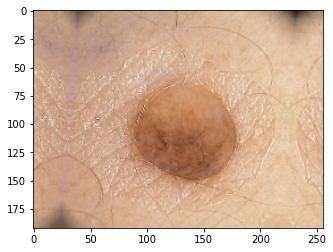

In [14]:
img = train_set[1][0].permute(1,2,0)
print(img.shape)
print(img)
plt.imshow(img)

torch.Size([192, 256, 1])
tensor([[[1.],
         [1.],
         [1.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [1.],
         [1.],
         [1.]]])


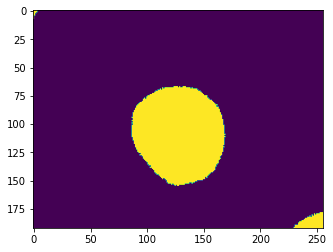

In [15]:
img = train_set[1][1].permute(1,2,0)
print(img.shape)
print(img)
plt.imshow(img)

## Model

In [16]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()
        
    def forward(self, inputs, targets, smooth=1e-6):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs*targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        
        IoU = (intersection + smooth) / (union + smooth)  # smooth to prevent 0/0
        
        return 1 - IoU

In [17]:
class BCEplusIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()
        
    def forward(self, inputs, targets, smooth=1e-6):
        
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs*targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        
        IoU = (intersection + smooth) / (union + smooth)  # smooth to prevent 0/0
        
        BCELoss = nn.BCELoss()
        BCE = BCELoss(inputs, targets)
        
        return 1 - IoU + BCE

In [18]:
class doubleConv(nn.Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, 3),
            nn.ReLU(),
            nn.Conv2d(outChannels, outChannels, 3),
        )
        
    def forward(self, x):
        return self.double_conv(x)

In [19]:
class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   groups=in_channels, bias=bias, padding=1)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 
                                   kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [20]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # DenseNet121 (decChannels: 1024,512,256,128)
        """
        model = models.densenet121(pretrained=True).features
        
        return_nodes = {
            "pool0": "feature1",
            "transition1.pool": "feature2",
            "transition2.pool": "feature3",
            "transition3.pool": "feature4",
            "norm5": "batchnorm"
        }
        
        self.encoder = create_feature_extractor(model, return_nodes=return_nodes)
        """
        
        # ResNet18 (decChannels: 512,256,128,64)
        """
        model = models.resnet18(pretrained=True)
        
        return_nodes = {
            "maxpool": "feature1",
            "layer1": "feature2",
            "layer2": "feature3",
            "layer3": "feature4",
            "layer4": "batchnorm"
        }
        
        self.encoder = create_feature_extractor(model, return_nodes=return_nodes)
        """
        
        # ResNet101 (decChannels: 2048,1024,512,256)
        
        model = models.resnet101(pretrained=True)
        
        return_nodes = {
            "maxpool": "feature1",
            "layer1": "feature2",
            "layer2": "feature3",
            "layer3": "feature4",
            "layer4": "batchnorm"
        }
        
        self.encoder = create_feature_extractor(model, return_nodes=return_nodes)
        
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        intermediate_outputs = self.encoder(x)
        blockOutputs = []
        
        for i, nodes in enumerate(intermediate_outputs):
            blockOutputs.append(intermediate_outputs[nodes])
    
        return blockOutputs

In [21]:
class Decoder(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        self.channels = channels
        self.upconvs = nn.ModuleList(
            [nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
                for i in range(len(channels) - 1)])
        self.separable_convs = nn.ModuleList(
            [SeparableConv2d(channels[i], channels[i + 1], 3)
                for i in range(len(channels) - 1)])
    
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            cropped_encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, cropped_encFeat], dim=1)
            x = self.separable_convs[i](x)
        # return the final decoder output
        return x
    
    def crop(self, encFeat, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        cropped_encFeat = transforms.CenterCrop([H, W])(encFeat)
        # return the cropped features
        return cropped_encFeat

In [22]:
class DSNet(nn.Module):
    def __init__(self, 
                 decChannels,
                 nbClasses=1, retainDim=True,
                 outSize=(config["image_height"], config["image_width"])):
        
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder()
        self.decoder = Decoder(decChannels)
        # initialize the regression head and store the class variables
        self.outconv = nn.Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
        
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:]) # ::-1 means reversed order
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.outconv(decFeatures)
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # return the segmentation map
        return map

In [31]:
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DSNet(decChannels = (2048,1024,512,256)).to(device)

""" change loss function """
# loss_func = nn.BCEWithLogitsLoss()
# loss_func = IoULoss()
loss_func = BCEplusIoULoss()

# optimizer = torch.optim.Adadelta(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=config["initial_lr"])

train_steps = len(train_set) / config["batch_size"]
valid_steps = len(valid_set) / config["batch_size"]
test_steps = len(valid_set) / config["batch_size"]

In [33]:
print("Training the network...")

best_loss = float("inf")
train_loss_history = []
train_iou_history = []
valid_loss_history = []
valid_iou_history = []

for epoch in range(config["n_epochs"]):
  
    model.train()
   
    total_train_loss = 0
    total_train_iou = 0
    total_valid_loss = 0
    total_valid_iou = 0
   
    
    for (i, (x, y)) in enumerate(tqdm(train_loader)):
     
        (x, y) = (x.to(device), y.to(device))
        
        logits = model(x)
        pred = torch.sigmoid(logits)                
        loss = loss_func(logits, y)
        iou = jaccard_index(pred, y.type(torch.int8), num_classes=2)
  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss
        total_train_iou += iou
        
    train_loss = total_train_loss / train_steps
    train_loss_history.append(train_loss.cpu().detach().numpy())
    train_iou = total_train_iou / train_steps
    train_iou_history.append(train_iou.cpu().detach().numpy())
    print(f'[ Train | {epoch + 1:03d}/{config["n_epochs"]:03d} ] loss = {train_loss:.5f} iou = {train_iou:.5f}')
    
    
    with torch.no_grad():
      
        model.eval()
        
        for (x, y) in tqdm(valid_loader):
      
            (x, y) = (x.to(device), y.to(device))
          
            logits = model(x)
            pred = torch.sigmoid(logits)
            loss = loss_func(logits, y)
            iou = jaccard_index(pred, y.type(torch.int8), num_classes=2)
        
            total_valid_loss += loss
            total_valid_iou += iou
            
        
    valid_loss = total_valid_loss / valid_steps
    valid_loss_history.append(valid_loss.cpu().detach().numpy())
    valid_iou = total_valid_iou / valid_steps
    valid_iou_history.append(valid_iou.cpu().detach().numpy())
    print(f'[ Valid | {epoch + 1:03d}/{config["n_epochs"]:03d} ] loss = {valid_loss:.5f} iou = {valid_iou:.5f}')
    
    # save models
    if valid_loss < best_loss:
        print(f"Best model found at epoch {epoch}, saving model")
        
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                # 'scheduler': scheduler.state_dict(),
                }, f'{config["model"]}_best.ckpt')

        best_loss = valid_loss

Training the network...


100%|██████████| 160/160 [00:16<00:00,  9.53it/s]


[ Train | 001/040 ] loss = 1.00163 iou = 0.68596


100%|██████████| 20/20 [00:00<00:00, 24.92it/s]


[ Valid | 001/040 ] loss = 2.99236 iou = 0.63466
Best model found at epoch 0, saving model


100%|██████████| 160/160 [00:17<00:00,  9.38it/s]


[ Train | 002/040 ] loss = 0.55070 iou = 0.82929


100%|██████████| 20/20 [00:00<00:00, 21.96it/s]


[ Valid | 002/040 ] loss = 1.17818 iou = 0.69105
Best model found at epoch 1, saving model


100%|██████████| 160/160 [00:16<00:00,  9.66it/s]


[ Train | 008/040 ] loss = 0.26669 iou = 0.88985


100%|██████████| 20/20 [00:00<00:00, 25.80it/s]


[ Valid | 008/040 ] loss = 4.62698 iou = 0.59516


100%|██████████| 160/160 [00:16<00:00,  9.58it/s]


[ Train | 009/040 ] loss = 0.27747 iou = 0.88005


100%|██████████| 20/20 [00:00<00:00, 28.00it/s]


[ Valid | 009/040 ] loss = 0.87169 iou = 0.70336


100%|██████████| 160/160 [00:15<00:00, 10.41it/s]


[ Train | 010/040 ] loss = 0.27199 iou = 0.88720


100%|██████████| 20/20 [00:00<00:00, 26.81it/s]


[ Valid | 010/040 ] loss = 0.97865 iou = 0.68388


100%|██████████| 160/160 [00:14<00:00, 11.07it/s]


[ Train | 011/040 ] loss = 0.22603 iou = 0.90099


100%|██████████| 20/20 [00:00<00:00, 27.34it/s]


[ Valid | 011/040 ] loss = 0.76177 iou = 0.74176


100%|██████████| 160/160 [00:17<00:00,  9.34it/s]


[ Train | 012/040 ] loss = 0.21530 iou = 0.90327


100%|██████████| 20/20 [00:01<00:00, 19.07it/s]


[ Valid | 012/040 ] loss = 0.71489 iou = 0.74398


100%|██████████| 160/160 [00:17<00:00,  9.10it/s]


[ Train | 013/040 ] loss = 0.20585 iou = 0.90595


100%|██████████| 20/20 [00:01<00:00, 19.02it/s]


[ Valid | 013/040 ] loss = 1.37205 iou = 0.71372


100%|██████████| 160/160 [00:18<00:00,  8.85it/s]


[ Train | 014/040 ] loss = 0.19882 iou = 0.90848


100%|██████████| 20/20 [00:00<00:00, 32.47it/s]


[ Valid | 014/040 ] loss = 1.25174 iou = 0.73614


100%|██████████| 160/160 [00:17<00:00,  9.33it/s]


[ Train | 015/040 ] loss = 0.25945 iou = 0.89297


100%|██████████| 20/20 [00:00<00:00, 21.11it/s]


[ Valid | 015/040 ] loss = 1.43316 iou = 0.69023


100%|██████████| 160/160 [00:17<00:00,  9.34it/s]


[ Train | 016/040 ] loss = 0.27854 iou = 0.88481


100%|██████████| 20/20 [00:00<00:00, 23.22it/s]


[ Valid | 016/040 ] loss = 0.85900 iou = 0.72371


100%|██████████| 160/160 [00:16<00:00,  9.44it/s]


[ Train | 017/040 ] loss = 0.25115 iou = 0.89644


100%|██████████| 20/20 [00:00<00:00, 27.13it/s]


[ Valid | 017/040 ] loss = 0.84832 iou = 0.73499


100%|██████████| 160/160 [00:15<00:00, 10.09it/s]


[ Train | 018/040 ] loss = 0.21396 iou = 0.90225


100%|██████████| 20/20 [00:00<00:00, 27.54it/s]


[ Valid | 018/040 ] loss = 1.06770 iou = 0.71630


100%|██████████| 160/160 [00:18<00:00,  8.87it/s]


[ Train | 019/040 ] loss = 0.20174 iou = 0.90995


100%|██████████| 20/20 [00:01<00:00, 19.87it/s]


[ Valid | 019/040 ] loss = 0.67536 iou = 0.76617


100%|██████████| 160/160 [00:17<00:00,  8.96it/s]


[ Train | 020/040 ] loss = 0.18256 iou = 0.91867


100%|██████████| 20/20 [00:00<00:00, 26.09it/s]


[ Valid | 020/040 ] loss = 0.65997 iou = 0.78360


100%|██████████| 160/160 [00:17<00:00,  9.04it/s]


[ Train | 021/040 ] loss = 0.18666 iou = 0.91220


100%|██████████| 20/20 [00:00<00:00, 26.03it/s]


[ Valid | 021/040 ] loss = 0.84995 iou = 0.77550


100%|██████████| 160/160 [00:17<00:00,  9.05it/s]


[ Train | 022/040 ] loss = 0.18404 iou = 0.91338


100%|██████████| 20/20 [00:00<00:00, 21.30it/s]


[ Valid | 022/040 ] loss = 0.91434 iou = 0.74121


100%|██████████| 160/160 [00:18<00:00,  8.83it/s]


[ Train | 023/040 ] loss = 0.18114 iou = 0.91896


100%|██████████| 20/20 [00:01<00:00, 17.50it/s]


[ Valid | 023/040 ] loss = 0.92542 iou = 0.69568


100%|██████████| 160/160 [00:16<00:00,  9.47it/s]


[ Train | 024/040 ] loss = 0.18634 iou = 0.91593


100%|██████████| 20/20 [00:01<00:00, 19.32it/s]


[ Valid | 024/040 ] loss = 0.68436 iou = 0.78158


100%|██████████| 160/160 [00:17<00:00,  9.19it/s]


[ Train | 025/040 ] loss = 0.19900 iou = 0.90972


100%|██████████| 20/20 [00:00<00:00, 23.86it/s]


[ Valid | 025/040 ] loss = 0.80389 iou = 0.74152


100%|██████████| 160/160 [00:17<00:00,  8.90it/s]


[ Train | 026/040 ] loss = 0.19054 iou = 0.91435


100%|██████████| 20/20 [00:00<00:00, 25.63it/s]


[ Valid | 026/040 ] loss = 1.36562 iou = 0.72081


100%|██████████| 160/160 [00:17<00:00,  9.41it/s]


[ Train | 027/040 ] loss = 0.19295 iou = 0.91151


100%|██████████| 20/20 [00:01<00:00, 14.15it/s]


[ Valid | 027/040 ] loss = 1.11939 iou = 0.73911


100%|██████████| 160/160 [00:14<00:00, 11.07it/s]


[ Train | 028/040 ] loss = 0.17542 iou = 0.91945


100%|██████████| 20/20 [00:00<00:00, 43.38it/s]


[ Valid | 028/040 ] loss = 1.06543 iou = 0.74537


100%|██████████| 160/160 [00:14<00:00, 11.31it/s]


[ Train | 029/040 ] loss = 0.19043 iou = 0.91532


100%|██████████| 20/20 [00:00<00:00, 34.57it/s]


[ Valid | 029/040 ] loss = 0.68845 iou = 0.77735


100%|██████████| 160/160 [00:14<00:00, 11.17it/s]


[ Train | 030/040 ] loss = 0.17271 iou = 0.92143


100%|██████████| 20/20 [00:00<00:00, 39.65it/s]


[ Valid | 030/040 ] loss = 0.85632 iou = 0.76697


100%|██████████| 160/160 [00:14<00:00, 11.08it/s]


[ Train | 031/040 ] loss = 0.44166 iou = 0.84564


100%|██████████| 20/20 [00:00<00:00, 36.24it/s]


[ Valid | 031/040 ] loss = 1.05682 iou = 0.67211


100%|██████████| 160/160 [00:14<00:00, 11.09it/s]


[ Train | 032/040 ] loss = 0.24167 iou = 0.89758


100%|██████████| 20/20 [00:00<00:00, 29.29it/s]


[ Valid | 032/040 ] loss = 0.95477 iou = 0.71981


100%|██████████| 160/160 [00:13<00:00, 11.51it/s]


[ Train | 033/040 ] loss = 0.19237 iou = 0.91008


100%|██████████| 20/20 [00:00<00:00, 34.17it/s]


[ Valid | 033/040 ] loss = 0.67313 iou = 0.77822


100%|██████████| 160/160 [00:12<00:00, 12.65it/s]


[ Train | 034/040 ] loss = 0.18651 iou = 0.91559


100%|██████████| 20/20 [00:00<00:00, 50.57it/s]


[ Valid | 034/040 ] loss = 1.08434 iou = 0.70710


100%|██████████| 160/160 [00:14<00:00, 11.15it/s]


[ Train | 035/040 ] loss = 0.18137 iou = 0.91754


100%|██████████| 20/20 [00:00<00:00, 49.11it/s]


[ Valid | 035/040 ] loss = 0.74991 iou = 0.75772


100%|██████████| 160/160 [00:14<00:00, 11.16it/s]


[ Train | 036/040 ] loss = 0.17528 iou = 0.92002


100%|██████████| 20/20 [00:00<00:00, 37.21it/s]


[ Valid | 036/040 ] loss = 0.92211 iou = 0.73150


 98%|█████████▊| 157/160 [00:14<00:00, 11.04it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



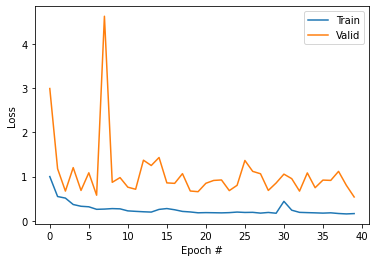

In [34]:
plt.figure()
plt.plot(train_loss_history, label="Train")
plt.plot(valid_loss_history, label="Valid")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

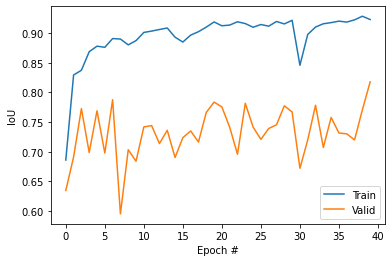

In [35]:
plt.figure()
plt.plot(train_iou_history, label="Train")
plt.plot(valid_iou_history, label="Valid")

plt.xlabel("Epoch #")
plt.ylabel("IoU")
plt.legend(loc="lower right")
plt.show()

## Prediction

In [36]:
model_best = DSNet(decChannels = (2048,1024,512,256)).to(device)
checkpoint = torch.load(f'{config["model"]}_best.ckpt')
model_best.load_state_dict(checkpoint["model_state_dict"])
model_best.eval()
total_test_iou = 0

for (x, y) in tqdm(test_loader):

    (x, y) = (x.to(device), y.to(device))

    logits = model_best(x)
    pred = torch.sigmoid(logits)
    iou = jaccard_index(pred, y.type(torch.int8), num_classes=2)
    total_test_iou += iou
    
test_iou = total_test_iou / test_steps
print("Test IoU:", test_iou)

100%|██████████| 20/20 [00:00<00:00, 32.90it/s]

Test IoU: tensor(0.9024, device='cuda:0')


In [37]:
def visualization(originImage, originMask, predMask, iou):
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
  
    ax[0].imshow(originImage)
    ax[1].imshow(originMask)
    ax[2].imshow(predMask)
   
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    t = ax[2].text(170, 20, f'IoU = {iou:.3f}')
    t.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='white'))
    figure.tight_layout()
    figure.show()

<Figure size 720x576 with 0 Axes>

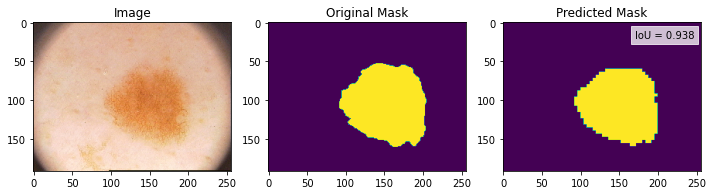

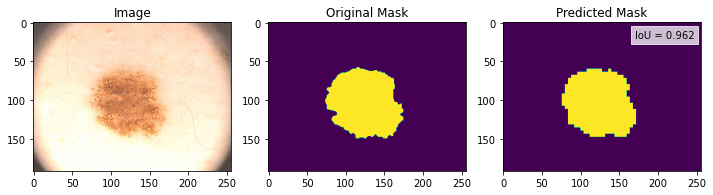

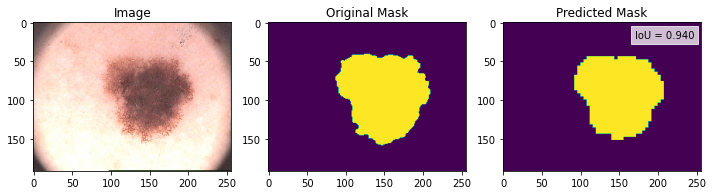

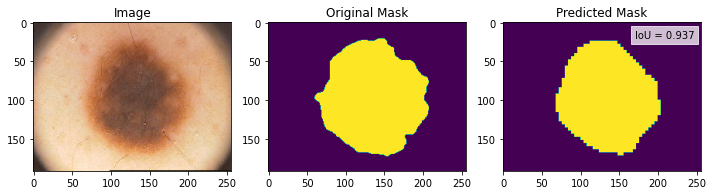

In [38]:
threshold = 0.5
fig = plt.figure(figsize=(10, 8))
outer = gridspec.GridSpec(4, 1, wspace=0.2, hspace=0.2)

for i in range(4):
    img, mask = test_set[i]
    (img, mask) = (img.to(device), mask.to(device))

    logits = model_best(img.unsqueeze(0))
    pred = torch.sigmoid(logits)
    iou = jaccard_index(pred, mask.type(torch.int8), num_classes=2)
    pred_mask = (pred > threshold).float()*1

    origin_img = img.permute(1,2,0).cpu().detach().numpy()
    origin_mask = mask.permute(1,2,0).cpu().detach().numpy()
    pred_mask = pred_mask.squeeze(0).permute(1,2,0).cpu().detach().numpy()
    
    
    inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    
    visualization(origin_img, origin_mask, pred_mask, iou)